<a href="https://colab.research.google.com/github/Vecheslav-Eremeev/sklearn_projects/blob/main/Titanic_test_classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

Load dataset 'Titanic'

In [ ]:
data = sns.load_dataset('titanic')

In [ ]:
data.keys()

Index(['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town',
       'alive', 'alone'],
      dtype='object')

In [ ]:
data.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [ ]:
data.shape

(891, 15)

Data preparation

In [ ]:
drop_keys = 'survived class who adult_male deck embark_town alive'.split()

In [ ]:
X = data.drop(drop_keys, axis=1)
y = data.survived

In [ ]:
X.head()

,pclass,sex,age,sibsp,parch,fare,embarked,alone
0,3,male,22.0,1,0,7.2500,S,False
1,1,female,38.0,1,0,71.2833,C,False
2,3,female,26.0,0,0,7.9250,S,True
3,1,female,35.0,1,0,53.1000,S,False
4,3,male,35.0,0,0,8.0500,S,True


In [ ]:
X.isnull().sum()

pclass        0
sex           0
age         177
sibsp         0
parch         0
fare          0
embarked      2
alone         0
dtype: int64

In [ ]:
X.embarked = X.embarked.fillna(X.embarked.mode()[0])

In [ ]:
X.age = X.age.fillna(X.age.mean())

In [ ]:
X.alone = X.alone.astype(int)

In [ ]:
X['family'] = X.sibsp + X.parch

In [ ]:
X = X.drop(['sibsp', 'parch'], axis=1)

In [ ]:
X.age = pd.cut(X.age, bins=8, labels=False)

In [ ]:
X.fare = pd.qcut(X.fare, 4, labels=False)

In [ ]:
X = pd.get_dummies(X, drop_first=True)

In [ ]:
X.sample(5)

,pclass,age,fare,alone,family,sex_male,embarked_Q,embarked_S
448,3,0,2,0,3,0,0,0
561,3,3,0,1,0,1,0,1
181,2,2,2,1,0,1,0,0
777,3,0,1,1,0,0,0,1
531,3,2,0,1,0,1,0,0


In [ ]:
test_size = 0.2
random_seed = 42

In [ ]:
num_folds = 10
n_estimators = 100
scoring = 'accuracy'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed)

Test Models

In [ ]:
models = [
          LogisticRegression(),
          LinearDiscriminantAnalysis(),
          KNeighborsClassifier(),
          DecisionTreeClassifier(),
          GaussianNB(),
          LinearSVC(),
          SVC(),
          MLPClassifier(),
          RandomForestClassifier(n_estimators=n_estimators),
          BaggingClassifier(n_estimators=n_estimators),
          AdaBoostClassifier(n_estimators=n_estimators),
          ExtraTreesClassifier(n_estimators=n_estimators),
          GradientBoostingClassifier(n_estimators=n_estimators),
          HistGradientBoostingClassifier(),
          XGBClassifier(silent=True),
          LGBMClassifier(silent=True)
]

In [ ]:
pipelines = []

In [ ]:
for model in models:
  name = model.__class__.__name__
  pipelines.append((name, model))

In [ ]:
scores = []
names = []
results = []
predictions = []
msgs = []

In [ ]:
def train_models(models):
  for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=random_seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold)
    names.append(name)
    results.append(cv_results)
    model.fit(X_train, y_train)
    predict = model.predict(X_test)
    predictions.append(predict)
    score = model.score(X_test, y_test)
    scores.append(score)
    msg = "%s: train = %.3f (%.3f) / test = %.3f" % (name, cv_results.mean(),
                                                     cv_results.std(), score)
    msgs.append(msg)
    print(msg)

In [ ]:
def show_results(title='Train Models'):
  fig = plt.figure()
  fig.suptitle(title)
  ax = fig.add_subplot(111)
  red_square = dict(markerfacecolor='r', marker='s')
  plt.boxplot(results, flierprops=red_square)
  ax.set_xticklabels(names, rotation=80)
  plt.show()

In [ ]:
train_models(pipelines)

LogisticRegression: train = 0.795 (0.039) / test = 0.799
LinearDiscriminantAnalysis: train = 0.792 (0.043) / test = 0.788
KNeighborsClassifier: train = 0.768 (0.061) / test = 0.793
DecisionTreeClassifier: train = 0.798 (0.047) / test = 0.788
GaussianNB: train = 0.761 (0.040) / test = 0.771
LinearSVC: train = 0.794 (0.037) / test = 0.799
SVC: train = 0.831 (0.055) / test = 0.816
MLPClassifier: train = 0.823 (0.044) / test = 0.793
RandomForestClassifier: train = 0.796 (0.049) / test = 0.810
BaggingClassifier: train = 0.798 (0.054) / test = 0.804
AdaBoostClassifier: train = 0.810 (0.047) / test = 0.782
ExtraTreesClassifier: train = 0.795 (0.051) / test = 0.799
GradientBoostingClassifier: train = 0.826 (0.043) / test = 0.810
HistGradientBoostingClassifier: train = 0.813 (0.057) / test = 0.832
XGBClassifier: train = 0.827 (0.041) / test = 0.821
LGBMClassifier: train = 0.812 (0.056) / test = 0.832


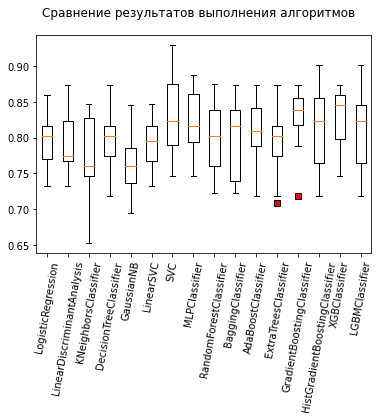

In [ ]:
show_results('Сравнение результатов выполнения алгоритмов')

StandardScaler

In [ ]:
pipelines = []

In [ ]:
for model in models:
  name = 'SS ' + model.__class__.__name__
  pipelines.append((name, Pipeline([('Scaler', StandardScaler()), 
                                    (model.__class__.__name__, model)])))

In [ ]:
scores = []
names = []
results = []
predictions = []
msgs = []

In [ ]:
train_models(pipelines)

SS LogisticRegression: train = 0.795 (0.039) / test = 0.799
SS LinearDiscriminantAnalysis: train = 0.792 (0.043) / test = 0.788
SS KNeighborsClassifier: train = 0.803 (0.059) / test = 0.765
SS DecisionTreeClassifier: train = 0.798 (0.044) / test = 0.782
SS GaussianNB: train = 0.761 (0.040) / test = 0.771
SS LinearSVC: train = 0.796 (0.039) / test = 0.799
SS SVC: train = 0.815 (0.043) / test = 0.804
SS MLPClassifier: train = 0.824 (0.056) / test = 0.793
SS RandomForestClassifier: train = 0.803 (0.052) / test = 0.810
SS BaggingClassifier: train = 0.798 (0.052) / test = 0.827
SS AdaBoostClassifier: train = 0.810 (0.047) / test = 0.782
SS ExtraTreesClassifier: train = 0.802 (0.053) / test = 0.799
SS GradientBoostingClassifier: train = 0.826 (0.043) / test = 0.810
SS HistGradientBoostingClassifier: train = 0.813 (0.057) / test = 0.832
SS XGBClassifier: train = 0.827 (0.041) / test = 0.821
SS LGBMClassifier: train = 0.813 (0.057) / test = 0.832


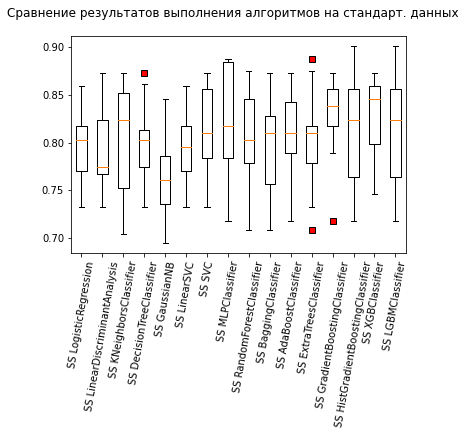

In [ ]:
show_results('Сравнение результатов выполнения алгоритмов на стандарт. данных')

Normalizer

In [ ]:
pipelines = []

In [ ]:
for model in models:
  name = 'N ' + model.__class__.__name__
  pipelines.append((name, Pipeline([('Normalizer', Normalizer()), 
                                    (model.__class__.__name__, model)])))

In [ ]:
scores = []
names = []
results = []
predictions = []
msgs = []

In [ ]:
train_models(pipelines)

N LogisticRegression: train = 0.767 (0.041) / test = 0.743
N LinearDiscriminantAnalysis: train = 0.779 (0.036) / test = 0.765
N KNeighborsClassifier: train = 0.802 (0.045) / test = 0.810
N DecisionTreeClassifier: train = 0.802 (0.041) / test = 0.793
N GaussianNB: train = 0.715 (0.039) / test = 0.749
N LinearSVC: train = 0.782 (0.036) / test = 0.771
N SVC: train = 0.823 (0.053) / test = 0.799
N MLPClassifier: train = 0.799 (0.044) / test = 0.760
N RandomForestClassifier: train = 0.787 (0.052) / test = 0.827
N BaggingClassifier: train = 0.791 (0.044) / test = 0.821
N AdaBoostClassifier: train = 0.786 (0.054) / test = 0.771
N ExtraTreesClassifier: train = 0.798 (0.051) / test = 0.810
N GradientBoostingClassifier: train = 0.803 (0.039) / test = 0.799
N HistGradientBoostingClassifier: train = 0.794 (0.045) / test = 0.832
N XGBClassifier: train = 0.805 (0.046) / test = 0.816
N LGBMClassifier: train = 0.795 (0.040) / test = 0.827


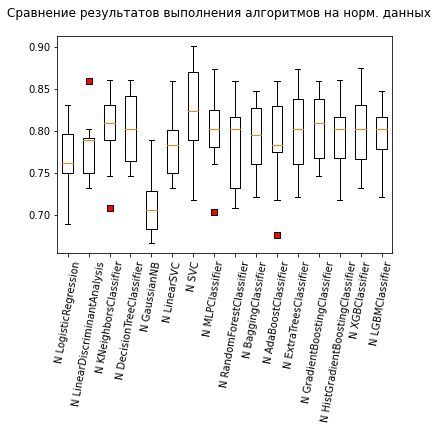

In [ ]:
show_results('Сравнение результатов выполнения алгоритмов на норм. данных')

MinMaxScaler

In [ ]:
pipelines = []

In [ ]:
for model in models:
  name = 'MinMax ' + model.__class__.__name__
  pipelines.append((name, Pipeline([('MinMaxScaler', MinMaxScaler()), 
                                    (model.__class__.__name__, model)])))

In [ ]:
scores = []
names = []
results = []
predictions = []
msgs = []

In [ ]:
train_models(pipelines)

MinMax LogisticRegression: train = 0.791 (0.041) / test = 0.782
MinMax LinearDiscriminantAnalysis: train = 0.792 (0.043) / test = 0.788
MinMax KNeighborsClassifier: train = 0.792 (0.046) / test = 0.793
MinMax DecisionTreeClassifier: train = 0.796 (0.046) / test = 0.788
MinMax GaussianNB: train = 0.761 (0.040) / test = 0.771
MinMax LinearSVC: train = 0.794 (0.040) / test = 0.799
MinMax SVC: train = 0.805 (0.029) / test = 0.793
MinMax MLPClassifier: train = 0.809 (0.039) / test = 0.804
MinMax RandomForestClassifier: train = 0.795 (0.056) / test = 0.810
MinMax BaggingClassifier: train = 0.794 (0.052) / test = 0.832
MinMax AdaBoostClassifier: train = 0.810 (0.047) / test = 0.782
MinMax ExtraTreesClassifier: train = 0.799 (0.048) / test = 0.799
MinMax GradientBoostingClassifier: train = 0.826 (0.043) / test = 0.810
MinMax HistGradientBoostingClassifier: train = 0.813 (0.057) / test = 0.832
MinMax XGBClassifier: train = 0.827 (0.041) / test = 0.821
MinMax LGBMClassifier: train = 0.812 (0.056

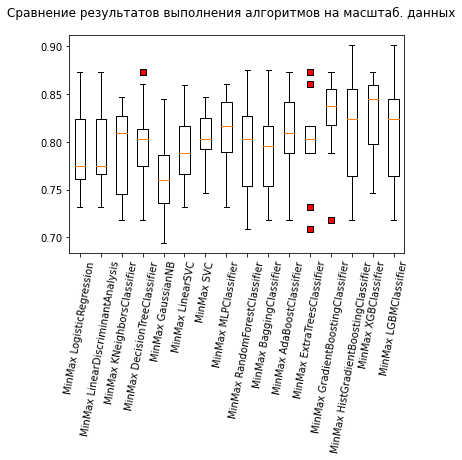

In [ ]:
show_results('Сравнение результатов выполнения алгоритмов на масштаб. данных')